# DRLND Project 1: Navigation

---

This is the notebook for project 1 of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Import the Required Packages

In [1]:
from unityagents import UnityEnvironment
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

from collections import deque

from dqn_agent import Agent

### 2. Instantiate the Environment and Agent

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

In [2]:
file_name = "Banana.x86_64"

# instantiate the Unity environment
env = UnityEnvironment(file_name=file_name)

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [3]:
# number of agents in the environment
print(f'Number of agents:   {len(env_info.agents):>3}')

# number of actions
action_size = brain.vector_action_space_size
print(f'Number of actions:  {action_size:>3}')

# examine the state space 
state = env_info.vector_observations[0]
state_size = len(state)
print(f'States have length: {state_size:>3}')

Number of agents:     1
Number of actions:    4
States have length:  37


### 3. Train the Agent with DQN

When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [4]:
# instantiate the agent
agent = Agent(state_size, action_size, seed=0)

In [5]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    
    for i_episode in range(1, n_episodes + 1):
        env_info = env.reset(train_mode=True)[brain_name]   # reset the environment for each episode
        state = env_info.vector_observations[0]             # get the current state
        score = 0                                           # initialize the score

        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]               # send the action to the environment
            next_state = env_info.vector_observations[0]          # get the next state         
            reward = env_info.rewards[0]                          # get the reward
            done = env_info.local_done[0]                         # check if episode is done

            score += reward                                       # update the score

            agent.step(state, action, reward, next_state, done)

            state = next_state
            
            if done:
                break
                
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        
        print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}', end="")

        if i_episode % 100 == 0:
            print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}')
        
        if np.mean(scores_window)>=15:
            print(f'\nEnvironment solved in {i_episode-100:d} episodes!\tAverage Score: {np.mean(scores_window):.2f}')
            
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')

            break
                  
    return scores

Episode 100	Average Score: 1.00
Episode 200	Average Score: 4.14
Episode 300	Average Score: 7.55
Episode 400	Average Score: 10.66
Episode 500	Average Score: 13.34
Episode 600	Average Score: 13.40
Episode 700	Average Score: 14.55
Episode 745	Average Score: 15.01
Environment solved in 645 episodes!	Average Score: 15.01


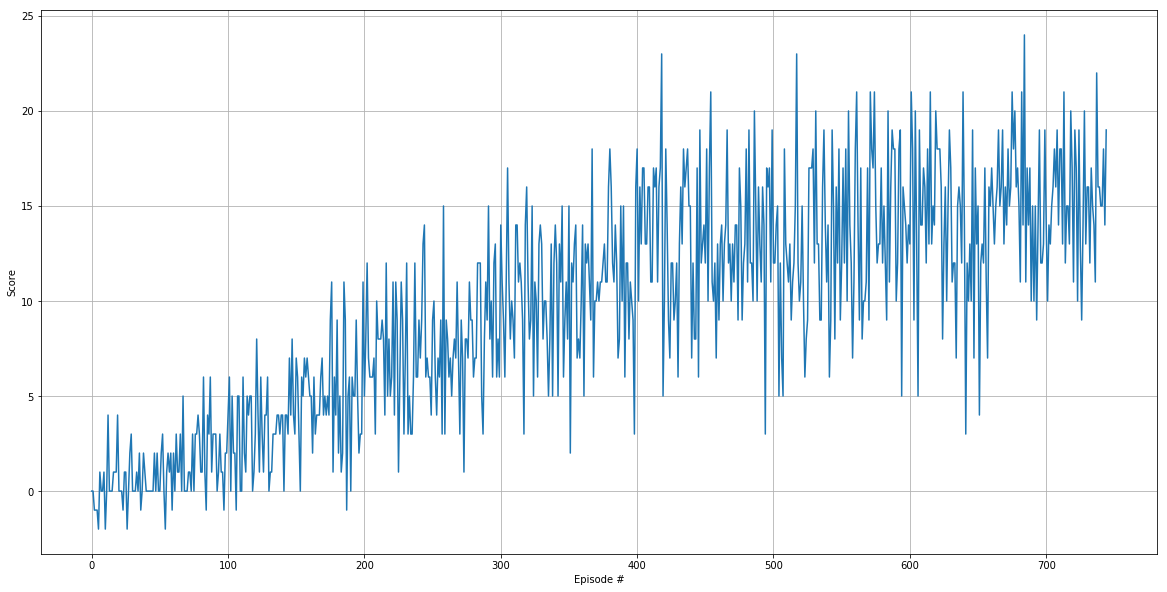

In [6]:
scores = dqn()

# plot the scores
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)

plt.ylabel('Score')
bottom, top = plt.ylim()
plt.ylim(bottom, 25)

plt.xlabel('Episode #')
left, right = plt.xlim()
plt.xlim(0, right)

plt.grid(True)
plt.rcParams.update({'font.size': 48})

plt.show()

### 4. Run the Trained Agent

To run the trained agent, load the weights from `checkpoint.pth`, reset the environment with `train_mode=False` and the score reset to $0$, then run until done.

In [7]:
# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

In [12]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score

while True:
    action = agent.act(state)                      # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    
    score += reward                                # update the score
    
    agent.step(state, action, reward, next_state, done)
    
    state = next_state
    
    if done:                                       # exit loop if episode finished
        break
    
print(f'score: {score}')

score: 15.0


### When finished, you can close the environment.

In [13]:
env.close()